Challenge: What is the influence of the different airlines/airports on the flight delays?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

/Users/teframartin/Informatik/Swisscom/.venv/lib/python3.11/site-packages/torch_geometric/typing.py:73: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/teframartin/Informatik/Swisscom/.venv/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <21041E56-CF21-33E4-ACA7-C80CF53AF089> /Users/teframartin/Informatik/Swisscom/.venv/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <E854E4B4-D8A9-321E-9852-69F8F3B956BB> /Users/teframartin/Informatik/Swisscom/.venv/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/teframartin/Informatik/Swisscom/.venv/lib/python3.11/site-packages/torch_geometric/typing.py:111: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/teframartin/Informa

In [2]:
df_airlines = pd.read_csv('data/airlines.csv')
df_airports = pd.read_csv('data/airports.csv')
df_flights = pd.read_csv('data/flights.csv')

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_33871/155576870.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv('data/flights.csv')


In [3]:
# some cleaning
df = df_flights[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIRLINE', 'DISTANCE']]

df = df.dropna()
# discard flights with airport codes that are not in the airports dataset
df = df[df['ORIGIN_AIRPORT'].isin(df_airports['IATA_CODE'])]
print(df.shape)

(5231130, 6)


# 1. Simple models

In [4]:
df_light = df.sample(frac=0.1, random_state=1)

In [5]:
mod = smf.ols(formula='ARRIVAL_DELAY ~ C(DESTINATION_AIRPORT) + C(AIRLINE)', data=df_light)

In [6]:
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     12.56
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:49:39   Log-Likelihood:            -2.6659e+06
No. Observations:              523113   AIC:                         5.332e+06
Df Residuals:                  522778   BIC:                         5.336e+06
Df Model:                         334                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Given the low R-squared value, this model explains a very small portion of the variance in flight delays. While some predictors are statistically significant, indicating a relationship between specific airlines/airports and arrival delays, the overall model suggests that there are many other factors not captured by this analysis that influence flight delays.

### Airlines - delay:
Lets see if there is a correlation between the airline and the delay of the flight.

In [7]:
df_light = df.sample(frac=0.1, random_state=10)

X =  df_light[['AIRLINE']]
y = df_light['ARRIVAL_DELAY']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = LinearRegression().fit(X_train, y_train)
print("Score:",model.score(X_train, y_train))

y_pred = model.predict(X_test)

# Evaluate the model
print("MSE:", mean_squared_error(y_test, y_pred))

Score: 0.004975063634228505
MSE: 1528.5907842335373


The score is really low, and the MSE is really high, so we need to improve the model.

### Airports - delay:
Lets see if there is a correlation between the airport and the delay of the flight.

In [9]:
df_light = df.sample(frac=0.01, random_state=10)

X =  df_light[['DESTINATION_AIRPORT']]
y = df_light['ARRIVAL_DELAY']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = LinearRegression().fit(X_train, y_train)
print("Score:",model.score(X_train, y_train))

y_pred = model.predict(X_test)

# Evaluate the model
print("MSE:", mean_squared_error(y_test, y_pred))

Score: 0.008196901675861401
MSE: 1708.8629135826836


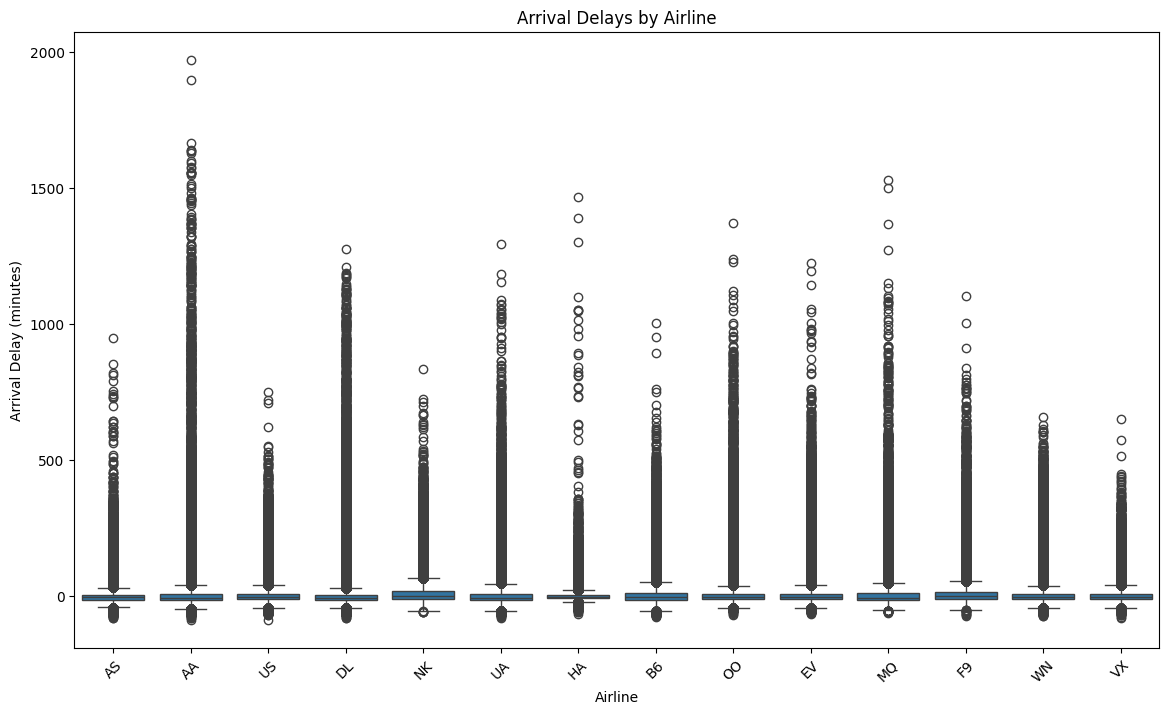

In [11]:
# Boxplot of Arrival Delays by Airline
plt.figure(figsize=(14, 8))
sns.boxplot(x='AIRLINE', y='ARRIVAL_DELAY', data=df_flights)
plt.title('Arrival Delays by Airline')
plt.xticks(rotation=45)
plt.xlabel('Airline')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

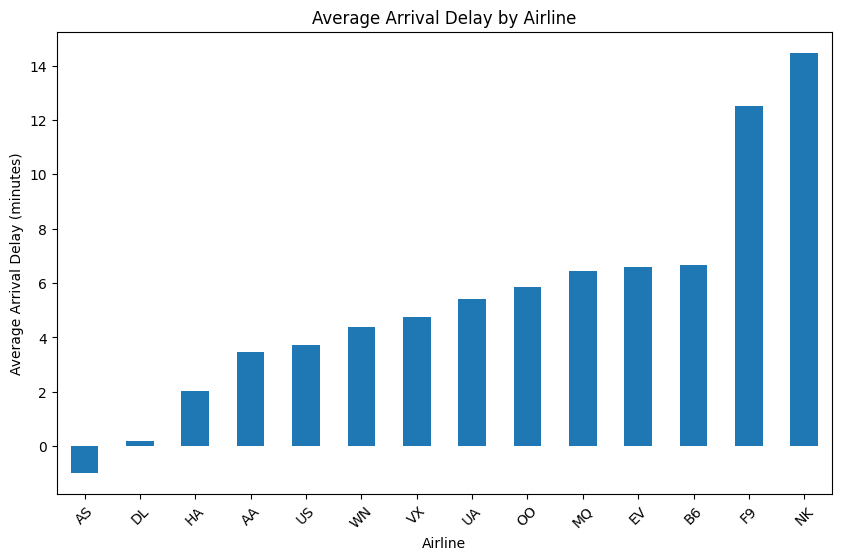

In [12]:
# Average departure delay by airline
avg_delay_airline = df_flights.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_delay_airline.plot(kind='bar')
plt.title('Average Arrival Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.show()

# Similarly, you can explore delays by airports

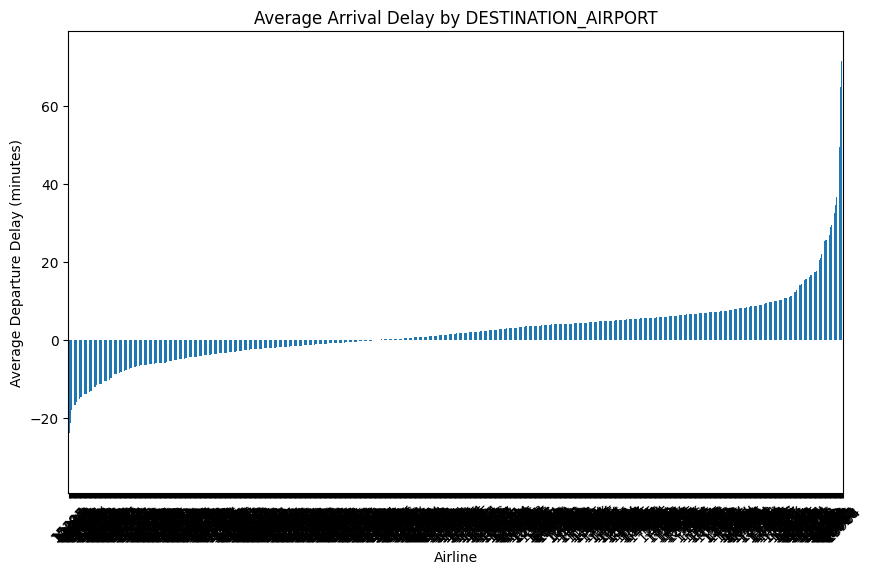

In [13]:
# Average departure delay by airports
avg_delay_airline = df_flights.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_delay_airline.plot(kind='bar')
plt.title('Average Arrival Delay by DESTINATION_AIRPORT')
plt.xlabel('Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.show()

# 2. Complex model

In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1


In [5]:
df_light = df.sample(frac=0.01, random_state=10)
print(df_light.keys())
# tansform string to int
df_light['ORIGIN_AIRPORT'] = pd.Categorical(df_light['ORIGIN_AIRPORT'])
df_light['DESTINATION_AIRPORT'] = pd.Categorical(df_light['DESTINATION_AIRPORT'])
df_light['AIRLINE'] = pd.Categorical(df_light['AIRLINE'])

df_light['ORIGIN_AIRPORT'] = df_light['ORIGIN_AIRPORT'].cat.codes
df_light['DESTINATION_AIRPORT'] = df_light['DESTINATION_AIRPORT'].cat.codes
df_light['AIRLINE'] = df_light['AIRLINE'].cat.codes

Index(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY',
       'ARRIVAL_DELAY', 'AIRLINE', 'DISTANCE'],
      dtype='object')


In [295]:
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx

G = nx.MultiDiGraph()

for flight in df_light.itertuples():
    G.add_edge(flight.ORIGIN_AIRPORT, flight.DESTINATION_AIRPORT, airline=flight.AIRLINE, arrival_delay=flight.ARRIVAL_DELAY)
    G.add_node(flight.ORIGIN_AIRPORT, name=flight.ORIGIN_AIRPORT)

In [68]:
import torch
from torch_geometric.data import Data
import numpy as np

from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch_geometric.data import Data

# Create edge index
edge_index = torch.tensor([list(edge) for edge in G.edges()], dtype=torch.long).t().contiguous()

# Create edge attributes (we'll just use arrival_delay here, but you could include more)
# include airline attribute
# edge_attr = torch.tensor([G[u][v][key][['arrival_delay', 'airline']] for u, v, key in G.edges(keys=True)], dtype=torch.float)   
edge_attrs = []
for u, v, key in G.edges(keys=True):
    arrival_delay = G[u][v][key]['arrival_delay']
    airline = G[u][v][key]['airline']
    # Convert 'airline' to a numerical representation if it's categorical
    # For simplicity, let's assume 'airline' is already numerical or has been converted earlier
    edge_attrs.append([arrival_delay, airline])

edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

# If your nodes have features, create them here
# For simplicity, we'll just use one-hot encoded node IDs as features
nodes = list(G.nodes())
node_indices = {node: i for i, node in enumerate(nodes)}
node_features = torch.eye(len(nodes))

data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr) #.view(-1, 1))


# Assuming departure_delays, arrival_delays, and distances are your edge features
# departure_delays = df_light['DEPARTURE_DELAY'].values
# arrival_delays = df_light['ARRIVAL_DELAY'].values
# distances = df_light['DISTANCE'].values
airline = df_light['AIRLINE'].values
departure_airport = df_light['ORIGIN_AIRPORT'].values
arrival_airport = df_light['DESTINATION_AIRPORT'].values

# features = np.stack((departure_delays, arrival_delays), axis=1)
features = np.stack((departure_airport, arrival_airport, airline), axis=1)

# # Normalize features
scaler = StandardScaler().fit(features)
scaled_features = scaler.transform(features)

# Convert to tensor
scaled_edge_features = torch.tensor(scaled_features, dtype=torch.float)

# Assuming the rest of your graph data is ready
# edge_index and node_features need to be prepared as shown in previous steps


--- Debut test ---

In [180]:
from sklearn.preprocessing import LabelEncoder

airports_encoder = LabelEncoder()
airports = np.concatenate([df_light['ORIGIN_AIRPORT'].values, df_light['DESTINATION_AIRPORT'].values])
airports_encoder.fit(airports)

# Convert airports in your DataFrame to their encoded values
departure_airport_encoded = airports_encoder.transform(df_light['ORIGIN_AIRPORT'].values)
arrival_airport_encoded = airports_encoder.transform(df_light['DESTINATION_AIRPORT'].values)

# Create edges (source, target) pairs
edges = torch.tensor([departure_airport_encoded, arrival_airport_encoded], dtype=torch.float)
edge_features = torch.tensor(np.stack((departure_airport, arrival_airport, airline, arrival_delay), axis=1), dtype=torch.float)

# Assuming edge_features is already defined as in your snippet
# edge_features = torch.tensor(np.stack((departure_airport, arrival_airport, airline, arrival_delay), axis=1), dtype=torch.float)

# Create a graph data object
data = Data(x=None, edge_index=edges, edge_attr=edge_features)
data

Data(edge_index=[2, 52311], edge_attr=[52311, 4])

In [78]:
data.edge_index[:, 0], data.edge_attr

(tensor([21., 18.]),
 tensor([[ 21.,  18.,   3., -12.],
         [ 19.,  82.,   3., -11.],
         [ 64., 172.,   0.,  18.],
         ...,
         [ 83., 272.,  10., -11.],
         [218., 172.,   0.,   9.],
         [280., 199.,   0.,   0.]]))

In [194]:
airline = df_light['AIRLINE'].values
departure_airport = df_light['ORIGIN_AIRPORT'].values
arrival_airport = df_light['DESTINATION_AIRPORT'].values
arrival_delay = df_light['ARRIVAL_DELAY'].values

edge_features = torch.tensor(np.stack((departure_airport, arrival_airport, airline, arrival_delay), axis=1))
node_features = torch.eye(len(
    set(df_light['ORIGIN_AIRPORT'].unique()).union(set(df_light['DESTINATION_AIRPORT'].unique()))
))
data = from_networkx(G, group_node_attrs=node_features,group_edge_attrs=edge_features)
data.validate(raise_on_error=True)
data

Data(edge_index=[2, 52311], x=[315, 1], edge_attr=[52311, 2])

In [250]:
from torch_geometric.nn import GCNConv, GATConv
from torch.nn import functional as F

class EnhancedGNN(torch.nn.Module):
    def __init__(self, node_feature_dim, edge_feature_dim):
        super(EnhancedGNN, self).__init__()
        self.conv1 = GCNConv(node_feature_dim, 128)
        self.conv2 = GCNConv(128, 32)
        self.edge_pred = torch.nn.Linear(edge_feature_dim, 1)
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x, edge_index, edge_features):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.edge_pred(torch.cat([x[edge_index[0]], x[edge_index[1]], edge_features], dim=1))
        return x
    
        

In [253]:
# Initialize model
model = EnhancedGNN(315, data.edge_attr.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Prepare target variable (only normalized arrival delays as targets)
target = data.edge_attr[:, -1].view(-1, 1)
data.edge_attr = data.edge_attr.float()
data.x = data.x.float()

matrix = torch.tensor(np.stack((departure_airport, arrival_airport, airline), axis=1), dtype=torch.float)

for epoch in range(10):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index, data.edge_attr)
    
    # Calculate loss against the normalized arrival delays
    loss = F.mse_loss(out, target)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (315x1 and 315x128)

In [244]:
data

Data(edge_index=[2, 52311], x=[315, 1], edge_attr=[52311, 2])

In [240]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(len(data.x), 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 1)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(315, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=1, bias=True)
)


In [241]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x.transpose(0, 1)[0], data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')
   

torch.Size([315]) torch.Size([2, 52311])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

--- Fin test ---

In [84]:
from torch_geometric.nn import GCNConv, GATConv
from torch.nn import functional as F

class EnhancedGNN(torch.nn.Module):
    def __init__(self, node_feature_dim, edge_feature_dim):
        super(EnhancedGNN, self).__init__()
        self.conv1 = GCNConv(node_feature_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.edge_pred = torch.nn.Linear(16 + edge_feature_dim, 1)  # Adjusted for combined node and edge features
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index, edge_features):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        
        # Prepare edge features for prediction by combining node and edge features
        edge_representations = torch.cat((x[edge_index[0]], edge_features), dim=1)
        edge_representations = self.dropout(edge_representations)
        return self.edge_pred(edge_representations)


In [85]:
# Initialize model
model = EnhancedGNN(node_features.shape[1], scaled_edge_features.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Prepare target variable (only normalized arrival delays as targets)
target = scaled_edge_features[:, 0].view(-1, 1)

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    
    # Assuming data.x is your node features and data.edge_index is your edge indices
    out = model(data.x, data.edge_index, scaled_edge_features)
    
    # Calculate loss against the normalized arrival delays
    loss = F.mse_loss(out, target)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.8133829236030579
Epoch 10, Loss: 0.6851291060447693
Epoch 20, Loss: 0.6101846098899841
Epoch 30, Loss: 0.555359959602356
Epoch 40, Loss: 0.5320484638214111
Epoch 50, Loss: 0.5138457417488098
Epoch 60, Loss: 0.5091419219970703
Epoch 70, Loss: 0.5131442546844482
Epoch 80, Loss: 0.5018209218978882
Epoch 90, Loss: 0.49790772795677185
Epoch 100, Loss: 0.5038595795631409
Epoch 110, Loss: 0.502190887928009
Epoch 120, Loss: 0.5016744136810303
Epoch 130, Loss: 0.5008479952812195
Epoch 140, Loss: 0.5003771781921387
Epoch 150, Loss: 0.50529545545578
Epoch 160, Loss: 0.49893784523010254
Epoch 170, Loss: 0.5013630390167236
Epoch 180, Loss: 0.4992818236351013
Epoch 190, Loss: 0.5038396120071411
Epoch 200, Loss: 0.5019757747650146
Epoch 210, Loss: 0.5016801953315735
Epoch 220, Loss: 0.4961232542991638
Epoch 230, Loss: 0.5015312433242798
Epoch 240, Loss: 0.5026795864105225
Epoch 250, Loss: 0.5020702481269836
Epoch 260, Loss: 0.49981167912483215
Epoch 270, Loss: 0.5028047561645508
Epoc

In [17]:
# L = nx.line_graph(G)

In [18]:
# L.edges(data=True)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104135890>>
Traceback (most recent call last):
  File "/Users/teframartin/Informatik/Swisscom/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [18]:
from torch_geometric.utils import from_networkx
import dgl

data = from_networkx(G, group_edge_attrs=True, group_node_attrs=True)

/Users/teframartin/Informatik/Swisscom/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data.validate()

True

In [19]:
src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
edge_pred_graph.edata['feature'] = torch.randn(1000, 10)
edge_pred_graph.edata['label'] = torch.randn(1000)
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

In [21]:
import dgl.function as fn
import torch.nn as nn

class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [22]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [25]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [26]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [32]:
from torch.nn import MSELoss
criterion = MSELoss()

node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(10, 20, 5)
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    pred = model(edge_pred_graph, node_features)
    loss = criterion(pred[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

59.16276931762695
55.35385513305664
51.84461212158203
48.61788558959961
45.64942169189453
42.924922943115234
40.427513122558594
38.139007568359375
36.04061508178711
34.11659240722656


In [323]:
# create training and testing sets
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes // 2] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes // 2:] = 1

In [324]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    train()
    test_acc = test()
    print(f'Epoch: {epoch:03d}, Test: {test_acc:.4f}')

RuntimeError: Found dtype Long but expected Float

In [301]:
data

Data(edge_index=[2, 52311], name=[315], airline=[52311], departure_delay=[52311], arrival_delay=[52311], distance=[52311], num_nodes=315)

In [291]:
import torch

num_nodes = data.num_nodes
# Randomly select 80% of the nodes for training and the rest for testing
indices = torch.randperm(num_nodes)
train_size = int(0.8 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
test_mask[indices[train_size:]] = True

# Assign masks to the data object
data.train_mask = train_mask
data.test_mask = test_mask

# Split edges into train and test sets
num_edges = data.num_edges
indices = torch.randperm(num_edges)
train_size = int(0.8 * num_edges)

train_edge_index = data.edge_index[:, indices[:train_size]]
test_edge_index = data.edge_index[:, indices[train_size:]]

# You might also want to consider negative sampling to identify non-existent edges
# for testing the model's ability to distinguish existing from non-existing edges.

# Update your Data object or create new ones for training and testing
train_data = Data(edge_index=train_edge_index, num_nodes=num_nodes)
test_data = Data(edge_index=test_edge_index, num_nodes=num_nodes)

In [320]:
G = nx.MultiDiGraph()

for flight in df_light.itertuples():
    G.add_edge(flight.ORIGIN_AIRPORT, 
               flight.DESTINATION_AIRPORT, 
               departure_airport=flight.ORIGIN_AIRPORT,
               arrival_airport=flight.DESTINATION_AIRPORT, 
               airline=flight.AIRLINE, 
               arrival_delay=flight.ARRIVAL_DELAY)
    G.add_node(flight.ORIGIN_AIRPORT, name=flight.ORIGIN_AIRPORT)

In [300]:
# find flights where ORIGIN_AIRPORT==21
df_light[(df_light['ORIGIN_AIRPORT'] == 21) & (df_light['DESTINATION_AIRPORT'] == 18)].sort_values(by='ARRIVAL_DELAY')[['ARRIVAL_DELAY', 'AIRLINE']]
# df_light[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY', 'AIRLINE']]

,ARRIVAL_DELAY,AIRLINE
3280059,-19.0,3
4310657,-13.0,3
3894304,-13.0,3
2912202,-12.0,3
3060574,-9.0,5
1940555,-7.0,3
5324986,-6.0,3
870910,-5.0,3
3618369,-5.0,5
706928,-3.0,13


In [321]:
G.edges

OutMultiEdgeView([(21, 18, 0), (21, 18, 1), (21, 18, 2), (21, 18, 3), (21, 18, 4), (21, 18, 5), (21, 18, 6), (21, 18, 7), (21, 18, 8), (21, 18, 9), (21, 18, 10), (21, 18, 11), (21, 18, 12), (21, 18, 13), (21, 18, 14), (21, 18, 15), (21, 18, 16), (21, 18, 17), (21, 18, 18), (21, 79, 0), (21, 79, 1), (21, 79, 2), (21, 79, 3), (21, 79, 4), (21, 79, 5), (21, 79, 6), (21, 79, 7), (21, 79, 8), (21, 79, 9), (21, 79, 10), (21, 79, 11), (21, 79, 12), (21, 79, 13), (21, 79, 14), (21, 79, 15), (21, 79, 16), (21, 79, 17), (21, 79, 18), (21, 79, 19), (21, 79, 20), (21, 79, 21), (21, 79, 22), (21, 79, 23), (21, 79, 24), (21, 79, 25), (21, 79, 26), (21, 79, 27), (21, 79, 28), (21, 79, 29), (21, 79, 30), (21, 79, 31), (21, 79, 32), (21, 79, 33), (21, 79, 34), (21, 79, 35), (21, 79, 36), (21, 79, 37), (21, 79, 38), (21, 79, 39), (21, 79, 40), (21, 79, 41), (21, 79, 42), (21, 79, 43), (21, 79, 44), (21, 79, 45), (21, 79, 46), (21, 79, 47), (21, 79, 48), (21, 79, 49), (21, 64, 0), (21, 64, 1), (21, 64, 2

In [322]:
G.get_edge_data(21, 18, 0)

{'departure_airport': 21,
 'arrival_airport': 18,
 'airline': 3,
 'arrival_delay': -12.0}

In [323]:
# iport from_networkx from dgl
import dgl

dgl_graph = dgl.from_networkx(G, edge_attrs=['airline', 'arrival_delay', 'departure_airport', 'arrival_airport'], node_attrs=['name'])
dgl_graph

Graph(num_nodes=315, num_edges=52311,
      ndata_schemes={'name': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'airline': Scheme(shape=(), dtype=torch.int64), 'arrival_delay': Scheme(shape=(), dtype=torch.float32), 'departure_airport': Scheme(shape=(), dtype=torch.int64), 'arrival_airport': Scheme(shape=(), dtype=torch.int64)})

In [324]:
print(dgl_graph.edata.keys())
dgl_graph.edata["arrival_airport"].shape

dict_keys(['airline', 'arrival_delay', 'departure_airport', 'arrival_airport'])


torch.Size([52311])

In [326]:
edge_pred_graph

Graph(num_nodes=100, num_edges=1000,
      ndata_schemes={'feature': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'feature': Scheme(shape=(10,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [328]:
dgl_graph.edata.keys()

dict_keys(['airline', 'arrival_delay', 'departure_airport', 'arrival_airport'])

### Edge regression

In [349]:
import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [350]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [351]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [352]:
# create a train_mask
train_mask = torch.zeros(dgl_graph.num_edges(), dtype=torch.bool)
train_mask[:dgl_graph.num_edges() // 2] = 1
dgl_graph.edata['train_mask'] = train_mask

In [353]:
dgl_graph.edata['train_mask'].sum()/dgl_graph.num_edges()

tensor(0.5000)

In [355]:
node_features = dgl_graph.ndata['name']
edge_features = dgl_graph.edata[[]]
edge_label = dgl_graph.edata['arrival_delay']
train_mask = dgl_graph.edata['train_mask']

model = Model(edge_label, 20, 2)
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    pred = model(dgl_graph, ed)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got Tensor"

In [356]:
data

Data(edge_index=[2, 52311], x=[315, 1], edge_attr=[52311, 2])